In [1]:
import time
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from ymaeda_tools.dft import dft, exidft_cplx
from ymaeda_tools.read_stfun import create_timefunc_pow34
from ymaeda_tools.read_snapshot import read_snapshot_params, snapshot_stnloc
from ymaeda_tools.read_snapshot import snapshot_XYZ, read_snapshot_loc3D_fast, extract_snapshot

# This script verifies the Green's functions created by YMAEDA_TOOLS
# This script also verifies certain properties of the "true" Green's functions as well as the
# "effective" Green's functions used to perform the actual FDM calculations.

df = 0.002441406 # frequency step size used by YMAEDA_TOOLS
f = np.arange(0, df * 2049, df) # frequency half space
F = np.arange(0, df * 4096, df) # frequency full space

STATION = "SMN_UD_SMALL" # UD (z-direction) impulse to kick start the GF generation
#HDD_LOC = "/Users/ynatsume/jupyter_main/Shinmoedake Data/" 
HDD_LOC = "/Volumes/TOSHIBA_HDD/Final Year Projects/Shinmoedake Data/EIC_BACKUP/home/natsume/"
GREENS_FUNCTION = "pow34"

In [2]:
STARTTIME = time.time()

if GREENS_FUNCTION == 'pow5':
    print('pow5 chosen...')
    snapshot_dir = os.path.join(HDD_LOC, "GFpow5/", STATION, "PML/snapshot/")
    T, FT = create_timefunc_pow5(tp = 1, size = 121, t0 = 0, dt = 0.1)
    # using a time function of higher resolution might lead to better results?
    # T, FT = create_timefunc_pow5(tp = 1, size = 1001, t0 = 0, dt = 0.001)
    # PAD_BUFFER = np.zeros(len(F)-len(T))
    PAD_BUFFER = np.zeros(400)
    FTw = dft(np.hstack([PAD_BUFFER, FT, np.ones(len(F)-len(PAD_BUFFER)-len(FT))]))
    FT1 = FTw[0:len(f)] # keep only the first half
    # instead of creating and calculating TF and FT1, load the output values from YMAEDA_TOOLS?
    #T, FT = read_stfunseq2(stfun_dir)
    #F, FTw = read_stfunspecseq2(stfun_dir)
    #f = F[0:2049]
    #FT1 = FTw[0:2049]
elif GREENS_FUNCTION == 'pow34':
    print('pow34 chosen...')
    snapshot_dir = os.path.join(HDD_LOC, "GFpow34/", STATION, "PML/snapshot/")
    T, FT = create_timefunc_pow34(tp = 1, size = 121, t0 = 0, dt = 0.1)
    #T,FT = create_timefunc_pow34(tp = 1, size = 1001, t0 = 0, dt = 0.001)
    FTw = dft(np.hstack([FT, np.zeros(len(F)-len(FT))]))
    FT1 = FTw[0:len(f)] # keep only the first half
elif GREENS_FUNCTION == 'cos':
    print('cos chosen...')
    snapshot_dir = os.path.join(HDD_LOC, "GFcos/", STATION, "PML/snapshot/")
    T, FT = create_timefunc_cos(tp = 1, size = 121, t0 = 0, dt = 0.1)
    #T, FT = create_timefunc_cos(tp = 1, size = 1001, t0 = 0, dt = 0.001)
    FTw = dft(np.hstack([FT, np.zeros(len(F)-len(FT))]))
    FT1 = FTw[0:len(f)] # keep only the first half  

print("Time elapsed: {:.3f}s".format(time.time()-STARTTIME))

pow34 chosen...
Time elapsed: 0.603s


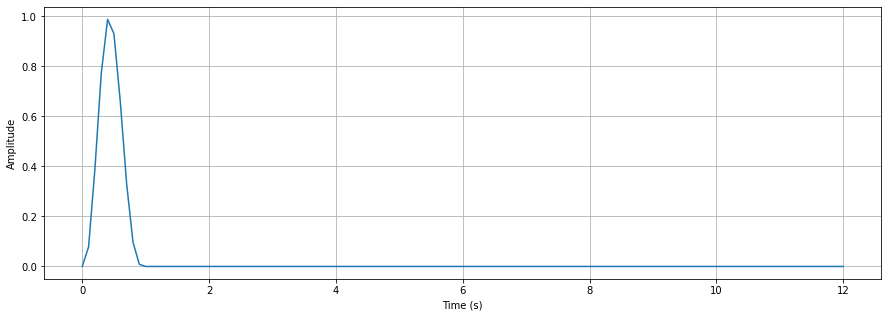

In [3]:
# Plot the source time function used to generate the "effective" Green's functions
plt.figure(figsize = (15, 5))
plt.plot(T, FT)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# Load the snapshot parameters from the .3db file output by YMAEDA_TOOLS
N, x0, dx = read_snapshot_params(snapshot_file = snapshot_dir + "source.Fx.t0.0000.3db")
print("N: {}, x0: {}, dx: {}.".format(N, x0, dx))

# Obtain the actual element indices!
# Seismometer and LP source locations:
# SMN: -11175, -119878, 1317
# SMW: -12295, -120893, 1110
# LP:  -10900, -121100, 1000
idx, idy, idz = snapshot_stnloc(N, x0, dx, -10900, -121100, 1000)
print("idx: {}, idy: {}, idz: {}.".format(idx, idy, idz))

# This is strictly not needed...
#X, Y, Z = snapshot_XYZ(N, x0, dx)

STARTTIME = time.time()
# read the Green's function snapshot at the specified location calculated by YMAEDA_TOOLS.
# This Green's function is not the true Green's function, but is the original Green's function
# convolved with the source time function: g'(t) = s(t) * g(t)
#t, g = read_snapshot_loc3D_fast(snapshot_dir = snapshot_dir, X = idx, Y = idy, Z = idz)

t, g = extract_snapshot(snapshot_dir, -10900, -121100, 1000)

print("Time elapsed: {:.3f}s".format(time.time()-STARTTIME))

N: (161, 160, 140), x0: (-11800.0, -121495.0, 5.0), dx: (10.0, 10.0, 10.0).
idx: 90, idy: 39, idz: 99.
Time elapsed: 174.319s


In [5]:
STARTTIME = time.time()
# read the Green's function snapshot at the specified location calculated by YMAEDA_TOOLS.
# This Green's function is not the true Green's function, but is the original Green's function
# convolved with the source time function: g'(t) = s(t) * g(t)

# read_snapshot_loc_3D_fast is outdated and has been replaced by extract_snapshot.
#t, g = read_snapshot_loc3D_fast(snapshot_dir = snapshot_dir, X = idx, Y = idy, Z = idz)
#t, g = extract_snapshot(snapshot_dir, -10900, -121100, 1000)

print("Time elapsed: {:.3f}s".format(time.time()-STARTTIME))

Time elapsed: 0.000s


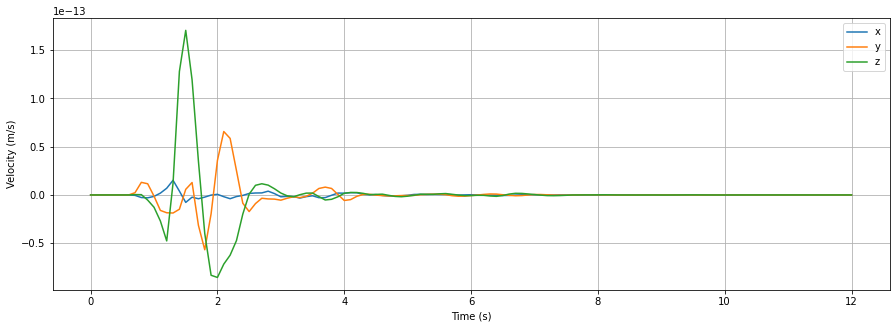

In [6]:
plt.figure(figsize = (15, 5))
plt.plot(t, g[:,0], t, g[:,1], t, g[:,2])
plt.legend(["x", "y", "z"])
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()

In [ ]:
# Instead of reading the 3 dimensional time series for a particular point for each station-impulse
# combination, in reality, the time series are loaded and processed differently. 
# For some ith direction motion recorded at some station, read the ith direction Green's functions
# for all 3 impulse directions at that station.
# E.g. SMN-X: G-XX G-XY G-XZ

In [ ]:
# In the next few sections, we confirm that the "effective" Green's functions are equal
# to the convolution of the "true" Green's functions and the source time function.

# "True" Green's functions cannot be simulated accurately due to the fact that a Dirac delta
# pulse is not numerically stable. A source time function is used to generate the pulse, and this
# results in "effective" Green's functions instead.

In [ ]:
STARTTIME = time.time()

# Zero pad the snapshot Green's functions with zeros, and perform DFT
if GREENS_FUNCTION == "pow34":
    G0 = dft(np.hstack([g[:,0], np.zeros(len(F)-len(g[:,0]))])) * (t[2]-t[1])
    G1 = dft(np.hstack([g[:,1], np.zeros(len(F)-len(g[:,0]))])) * (t[2]-t[1])
    G2 = dft(np.hstack([g[:,2], np.zeros(len(F)-len(g[:,0]))])) * (t[2]-t[1])
elif GREENS_FUNCTION == "pow5":
    G0 = dft(np.hstack([g[:,0], np.zeros(len(F)-len(g[:,0]))])) * (t[2]-t[1])
    G1 = dft(np.hstack([g[:,1], np.zeros(len(F)-len(g[:,1]))])) * (t[2]-t[1])
    G2 = dft(np.hstack([g[:,2], np.zeros(len(F)-len(g[:,2]))])) * (t[2]-t[1])
elif GREENS_FUNCTION == "cos":
    G0 = dft(np.hstack([g[:,0], np.zeros(len(F)-len(g[:,0]))])) * (t[2]-t[1])
    G1 = dft(np.hstack([g[:,1], np.zeros(len(F)-len(g[:,1]))])) * (t[2]-t[1])
    G2 = dft(np.hstack([g[:,2], np.zeros(len(F)-len(g[:,2]))])) * (t[2]-t[1])
    
G0 = G0[0:len(f)]
G1 = G1[0:len(f)]
G2 = G2[0:len(f)]

print("Time elapsed: {:.3f}s".format(time.time()-STARTTIME))

In [ ]:
STARTTIME = time.time()

# Numerical deconvolution in frequency space by simple division.
G00 = G0 / FT1
G10 = G1 / FT1
G20 = G2 / FT1
# iDFT to get the deconvolved signal in time space. Do not forget the 1/dt factor!
g00 = np.real(exidft_cplx(G00)) / (t[2]-t[1])
g10 = np.real(exidft_cplx(G10)) / (t[2]-t[1])
g20 = np.real(exidft_cplx(G20)) / (t[2]-t[1])

print("Time elapsed: {:.3f}s".format(time.time()-STARTTIME))

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(t, g00[:len(t)])
plt.plot(t, g10[:len(t)])
plt.plot(t, g20[:len(t)])
plt.legend(['x','y','z'])
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()

In [ ]:
# g[:,i] ("effective" Green's function) should equal the numerical convolution of 
# g00 ("true" Green's function) and FT (source time function)!
plt.figure(figsize = (15, 10))
if GREENS_FUNCTION == 'pow34':
    plt.subplot(3, 1, 1)
    plt.plot(t, np.convolve(g00[:len(t)], FT)[:len(t)], 'k')
    plt.plot(t, g[:,0], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.grid(True)
    plt.subplot(3, 1, 2)
    plt.plot(t, np.convolve(g10[:len(t)], FT)[:len(t)], 'k')
    plt.plot(t, g[:,1], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.ylabel("Velocity (m/s)")
    plt.grid(True)
    plt.subplot(3, 1, 3)
    plt.plot(t, np.convolve(g20[:len(t)], FT)[:len(t)], 'k')
    plt.plot(t, g[:,2], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.xlabel("Time (s)")
    plt.grid(True)
elif GREENS_FUNCTION == 'cos':
    plt.subplot(3, 1, 1)
    plt.plot(t[1:], np.convolve(g00, FT)[4096:], 'k')
    plt.plot(t, g[:,0], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.grid(True)
    plt.subplot(3, 1, 2)
    plt.plot(t[1:], np.convolve(g10, FT)[4096:], 'k')
    plt.plot(t, g[:,1], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.ylabel("Velocity (m/s)")
    plt.grid(True)
    plt.subplot(3, 1, 3)
    plt.plot(t[1:], np.convolve(g20, FT)[4096:], 'k')
    plt.plot(t, g[:,2], 'r.') 
    plt.legend(["Python", "runwaterPML"])
    plt.xlabel("Time (s)")
    plt.grid(True)
elif GREENS_FUNCTION == 'pow5':
    plt.subplot(3, 1, 1)
    plt.plot(t[:-1], np.convolve(g00[:len(t)], FT)[len(T):], 'k')
    plt.plot(t, g[:,0], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.grid(True)
    plt.subplot(3, 1, 2)
    plt.plot(t[:-1], np.convolve(g10[:len(t)], FT)[len(T):], 'k')
    plt.plot(t, g[:,1], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.ylabel("Velocity (m/s)")
    plt.grid(True)
    plt.subplot(3, 1, 3)
    plt.plot(t[:-1], np.convolve(g20[:len(t)], FT)[len(T):], 'k')
    plt.plot(t, g[:,2], 'r.')
    plt.legend(["Python", "runwaterPML"])
    plt.xlabel("Time (s)")
    plt.grid(True)
plt.show()